# RNN practice
- make simple RNN

first make a sample dataset

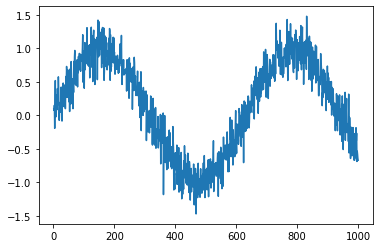

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
y = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# xs = [x for x in range(1,T+1)]


plt.plot(time, y)

In [2]:
# make chunks of data
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:,i] = y[i: T - tau + i]
labels = y[tau:].reshape((-1,1))

batch_size, n_train = 16, 600

In [3]:
class MyDataset(Dataset):
    '''
    Dataset class for my private dataset
    '''
    def __init__(self, data, y):
        self.y = y
        self.xs = data
        self.transform = None
        self.target_transform = None
        
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        data = self.xs
        y = self.y
        return data, y

train_dataset = MyDataset(features[:n_train], labels[:n_train])

In [4]:
features.shape
labels.shape

torch.Size([996, 1])

In [5]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
def init_weight(m):
    '''
    initializes weight with xavier uniform distribution
    '''
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
def get_net():
    '''
    function that makes net(NN)
    '''
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1))
    net.apply(init_weight)
    return net

# define loss function
loss = nn.MSELoss(reduction='none')
    

In [7]:
def train(net, train_iter, loss, epochs, lr):
    '''
    functionize a trainer
    '''
    # set an optimizer
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {l.sum()/batch_size}')

net = get_net()
train(net, train_iter, loss, 1000, 0.01)

epoch 1, loss: 201.09478759765625
epoch 2, loss: 67.35999298095703
epoch 3, loss: 71.68234252929688
epoch 4, loss: 53.75282669067383
epoch 5, loss: 53.69561767578125
epoch 6, loss: 50.348228454589844
epoch 7, loss: 49.21413040161133
epoch 8, loss: 47.93324279785156
epoch 9, loss: 47.132965087890625
epoch 10, loss: 46.44746398925781
epoch 11, loss: 45.938045501708984
epoch 12, loss: 45.516571044921875
epoch 13, loss: 45.166412353515625
epoch 14, loss: 44.879791259765625
epoch 15, loss: 44.650367736816406
epoch 16, loss: 44.47045135498047
epoch 17, loss: 44.33088684082031
epoch 18, loss: 44.225765228271484
epoch 19, loss: 44.144813537597656
epoch 20, loss: 44.08222579956055
epoch 21, loss: 44.034244537353516
epoch 22, loss: 43.99811935424805
epoch 23, loss: 43.969818115234375
epoch 24, loss: 43.9477653503418
epoch 25, loss: 43.92988967895508
epoch 26, loss: 43.914642333984375
epoch 27, loss: 43.90155029296875
epoch 28, loss: 43.889583587646484
epoch 29, loss: 43.878665924072266
epoch 30,

The loss is not getting any lower

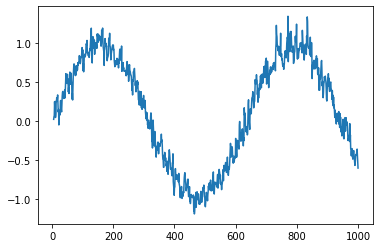

In [8]:
onestep_preds = net(features)
plt.plot(time[4:], onestep_preds.detach().numpy().squeeze())

although the model has some differences, the models still outputs a similar pattern from the $x$

In [71]:
features[1], labels[1], features[2], labels[2]

(tensor([-0.1614, -0.1524,  0.2271,  0.3456]),
 tensor([-0.0420]),
 tensor([-0.1524,  0.2271,  0.3456, -0.0420]),
 tensor([-0.0181]))

In [16]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = time[: n_train + tau]

In [38]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = y[: n_train + tau]

for i in range(n_train + tau, T): # 604 ~ 1000
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

# d2l.plot([time, time[tau:], time[n_train + tau:]],
#          [x.detach().numpy(), onestep_preds.detach().numpy(),
#           multistep_preds[n_train + tau:].detach().numpy()], 'time',
#          'x', legend=['data', '1-step preds', 'multistep preds'],
#          xlim=[1, 1000], figsize=(6, 3))

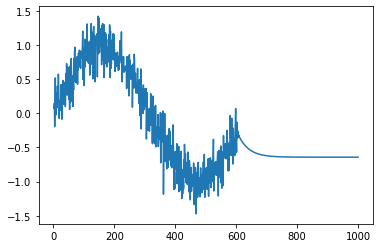

In [39]:
plt.plot(time.tolist(), multistep_preds.tolist())

We can see that the model does not learn the sequential pattern of the original data.\
How do we solve this problem?